In [2]:
from multiprocessing import Pool

import matplotlib.pyplot as plt
import msprime
import numpy as np

In [3]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 200
plt.rcParams['text.usetex'] = False 

## B Loss Limit

In [25]:
Bs = np.random.uniform(0, 1, 1000)

In [28]:
def bgs_runner(B, nreps=100):
    Bhats = np.array([msprime.sim_ancestry(N, population_size=B*N).diversity(mode='branch')/(4*N) for _ in range(nreps)])
    return np.mean((Bhats - B)**2)

with Pool(70) as p:
    res = np.array(p.map(bgs_runner, Bs))

In [41]:
def B_var(B, N, n, mu):
    #return (n+1) * B / (12*N*mu*(n-1)) + (2*(n**2 + n +3) *B**2)/(9*n*(n-1))
    return 2/9 * B**2


[]

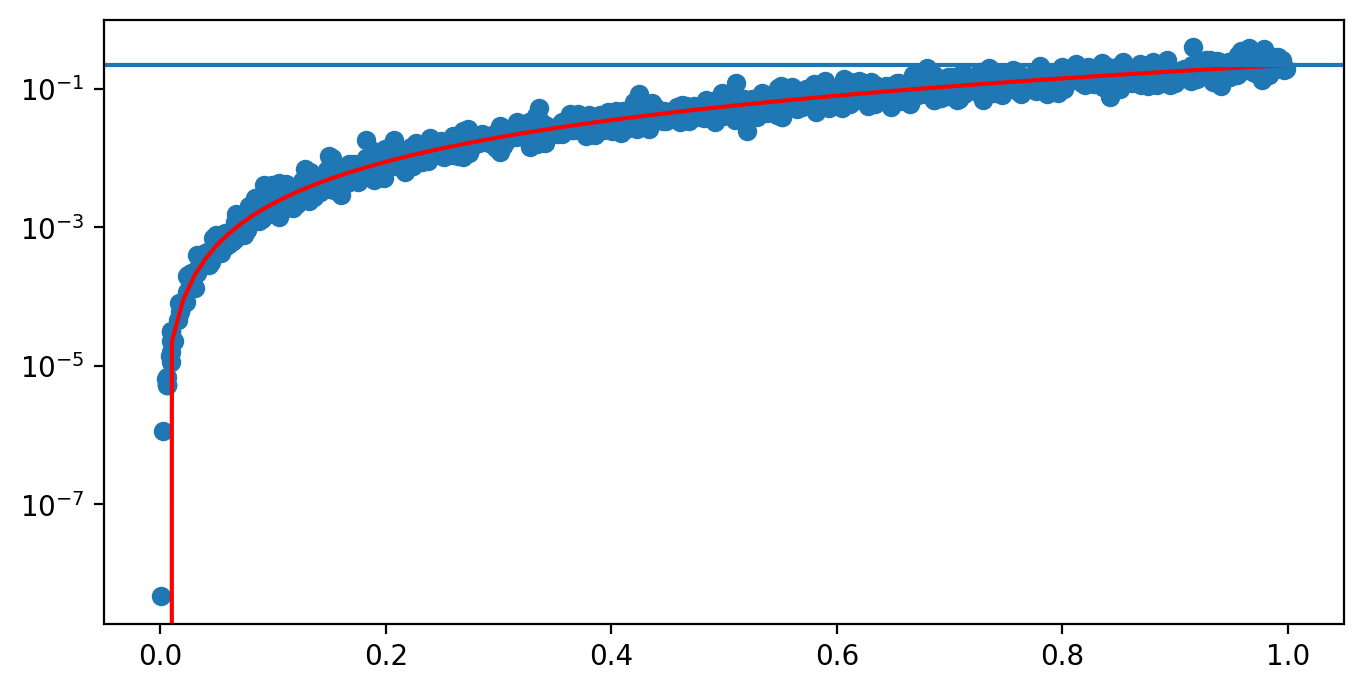

In [257]:
fig, ax = plt.subplots()
ax.scatter(Bs, res)
b = np.linspace(0, 1, 100)
ax.plot(b, B_var(b, 1000, 1000, 1), c='r')
ax.axhline(2/9)
ax.semilogy()

## Multiplicative Error of B

There are two possible error models:

1. Product error model, e.g. $B = \prod_i^n (B_i + \varepsilon_i)$
2. Rate error model, e.g. $B = \prod_i^n \exp(\lambda_i + \varepsilon_i)$

It's not clear which is appropriate — either way, we want to quantify $\mathrm{Var}(B)$.

### Product Error Model

$$ B = \prod_i^n (B_i + \varepsilon_i) $$
$$ \log(B) = \sum_i^n \log(B_i + \varepsilon_i) $$

Taylor expansion around $\varepsilon_i = 0$:

$$ \log(B) \approx \sum_i^n \log(B_i) + \sum_i^n \frac{\varepsilon_i}{B_i} $$

If $\varepsilon_i \sim N(0, \sigma^2)$, then each term of the sum can be written as a rescaled normal, e.g. $e_i \sim N(0, \sqrt{B_i} \sigma^2)$

$$ \log(B) \approx \sum_i^n \log(B_i) + \sum_i^n e_i $$


$$ B \approx \prod_i^n B_i \exp\left(\sum_i^n e_i\right) $$

$$ \mathrm{Var}(B) \approx \prod_i^n B_i \mathrm{Var}(X) $$

where $X = \exp\left(\sum_i^n e_i\right)$ is log-normally distributed with variance $c^2 = \sum_i^n\sqrt{B_i} \sigma^2$ (since the sum of log-normals is log-normal with summed mean and variance). Thus, 

$$ \mathrm{Var}(B) \approx \left(\prod_i^n B_i \right) (\exp(c^2)-1)\exp(2 \mu + c^2) $$

### Rate Error Model

The math of this model is much simpler since error only affects the rate.

$$B = \prod_i^n \exp(\lambda_i + \varepsilon_i)$$

$$\log(B) = \sum_i^n \lambda_i + \sum_i^n \varepsilon_i$$

We can see that this is now like the past problem, 

$$ \mathrm{Var}(B) \approx \prod_i^n B_i \mathrm{Var}(X) $$
 
where $X$ is also log-normal. Assuming i.i.d. $\varepsilon_i$ terms, $c^2 = n \sigma^2$



In [196]:
def product_error_model(b, sd, bias=0):
    B = np.prod(b)
    return np.mean([(np.prod(b + np.random.normal(bias, sd, len(b)))-B)**2 for _ in range(10)])

def rate_error_model(b, sd, bias=0):
    B = np.prod(b)
    rate = np.log(b)
    return np.mean([(np.prod(np.exp(rate + np.random.normal(bias, sd, len(b))))-B)**2 for _ in range(10)])

In [197]:
def product_var(b, sd, bias=0):
    c2 = np.sum(np.sqrt(b)) * sd**2
    return np.prod(b)**2*np.exp(c2 + 2*bias)*(np.exp(c2) - 1)

def rate_var(b, sd, bias=0):
    n = len(b)
    c2 = n * sd**2
    return np.prod(b)**2*np.exp(c2 + 2*bias)*(np.exp(c2) - 1)

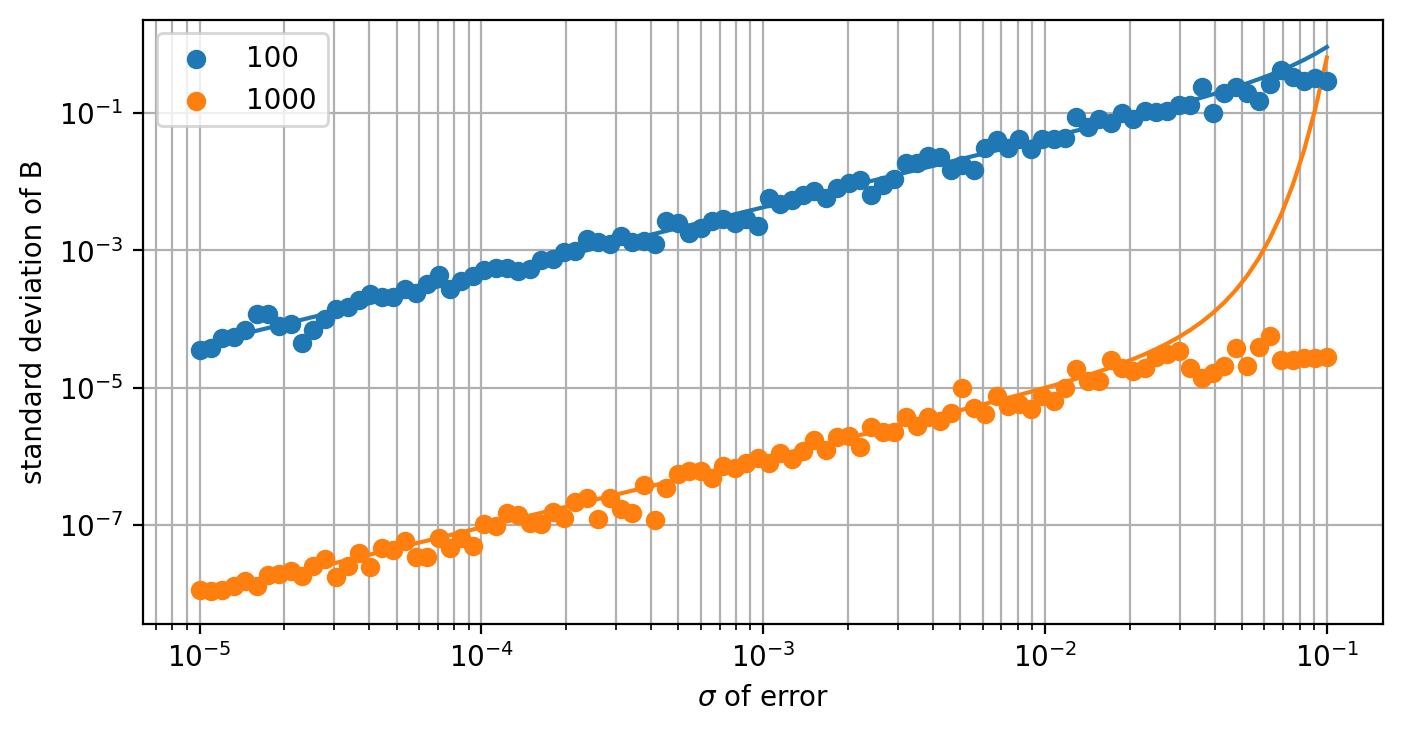

In [217]:
fig, ax = plt.subplots()

nsites = 100
b = np.random.beta(100, 1, nsites)

sd = 10**np.linspace(-5, -1, 100)
ax.scatter(sd, np.sqrt([np.mean(product_error_model(b, s)) for s in sd]), zorder=3, label=nsites)
#ax.scatter(sd, np.sqrt([np.mean(rate_error_model(b, s)) for s in sd]), zorder=3)
#ax.plot(sd, np.sqrt([product_var(b, s) for s in sd]))
ax.plot(sd, np.sqrt([rate_var(b, s) for s in sd]))

nsites = 1000
b = np.random.beta(100, 1, nsites)


sd = 10**np.linspace(-5, -1, 100)
ax.scatter(sd, np.sqrt([np.mean(product_error_model(b, s)) for s in sd]), zorder=3, label=nsites)
#ax.scatter(sd, np.sqrt([np.mean(rate_error_model(b, s)) for s in sd]), zorder=3)
#ax.plot(sd, np.sqrt([product_var(b, s) for s in sd]))
ax.plot(sd, np.sqrt([rate_var(b, s) for s in sd]))
ax.grid(which='both')
ax.set_ylabel("standard deviation of B")
ax.set_xlabel("$\sigma$ of error")
ax.loglog()
ax.legend()